In [8]:
import os
import string
import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

# 1. Drive Bağlantısı
drive.mount('/content/drive')

# 2. Yolları Tanımlama
ANA_KLASOR = '/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/Flickr8k_Data'
RESIM_KLASORU = os.path.join(ANA_KLASOR, 'Images')
CAPTION_DOSYASI = os.path.join(ANA_KLASOR, 'captions.txt')
OZELLIK_DOSYASI = '/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/features.pkl'

print(f"Ana Klasör: {ANA_KLASOR}")
print(f"Resimler: {RESIM_KLASORU}")
print(f"Metin Dosyası: {CAPTION_DOSYASI}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ana Klasör: /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/Flickr8k_Data
Resimler: /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/Flickr8k_Data/Images
Metin Dosyası: /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/Flickr8k_Data/captions.txt


In [10]:
def verileri_yukle_ve_temizle(filename):
    with open(filename, 'r') as file:
        text = file.read()

    mapping = {}
    ham_veri_ornekleri = {} # Rapor için ham hallerini saklayalım
    satirlar = text.split('\n')
    satirlar = satirlar[1:] # Başlığı atla

    table = str.maketrans('', '', string.punctuation)

    for satir in satirlar:
        tokens = satir.split(',')
        if len(tokens) < 2: continue

        # ID'den .jpg uzantısını atalım ki VGG çıktılarıyla eşleşsin
        image_id = tokens[0].split('.')[0]
        caption_raw = " ".join(tokens[1:]) # Ham hali

        # --- TEMİZLİK ---
        caption = caption_raw.lower()
        caption = caption.translate(table)
        caption = caption.split()
        caption = [word for word in caption if len(word) > 1]
        caption = [word for word in caption if word.isalpha()]

        # Token Ekleme
        caption_clean = 'startseq ' + ' '.join(caption) + ' endseq'

        # Sözlüğe ekle
        if image_id not in mapping:
            mapping[image_id] = []
            ham_veri_ornekleri[image_id] = [] # Rapor için

        mapping[image_id].append(caption_clean)
        ham_veri_ornekleri[image_id].append(caption_raw) # Rapor için ham hali

    return mapping, ham_veri_ornekleri


print("Metinler işleniyor...")
mapping, ham_veriler = verileri_yukle_ve_temizle(CAPTION_DOSYASI)
print(f"Toplam İşlenen Resim Sayısı: {len(mapping)}")

Metinler işleniyor...
Toplam İşlenen Resim Sayısı: 8091


In [11]:
# Eğer features.pkl zaten varsa yükle, yoksa VGG16 ile çıkar
if os.path.exists(OZELLIK_DOSYASI):
    print("Özellik dosyası bulundu! Tekrar işlem yapmaya gerek yok.")
    print("Dosyadan yükleniyor...")
    with open(OZELLIK_DOSYASI, 'rb') as f:
        features = pickle.load(f)
    print("Yüklendi!")
else:
    print("Özellik dosyası bulunamadı. VGG16 ile çıkarılıyor (Bu işlem zaman alabilir)...")

    # Modeli Kur
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    features = {}
    directory = os.listdir(RESIM_KLASORU)

    for img_name in tqdm(directory):
        if not img_name.endswith('.jpg'): continue

        # ID Hazırla
        image_id = img_name.split('.')[0]

        # Resim Yükle ve İşle
        img_path = os.path.join(RESIM_KLASORU, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)

        # Tahmin (Extract)
        feature = model.predict(image, verbose=0)
        features[image_id] = feature

    # Kaydet
    with open(OZELLIK_DOSYASI, 'wb') as f:
        pickle.dump(features, f)
    print(f"Özellikler kaydedildi: {OZELLIK_DOSYASI}")

print(f"Özellikleri çıkarılan toplam resim: {len(features)}")

Özellik dosyası bulunamadı. VGG16 ile çıkarılıyor (Bu işlem zaman alabilir)...


100%|██████████| 8091/8091 [1:45:49<00:00,  1.27it/s]


Özellikler kaydedildi: /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/features.pkl
Özellikleri çıkarılan toplam resim: 8091


--- RAPOR İÇİN ÖRNEK VERİ ANALİZİ (ID: 1110208841_5bb6806afe) ---


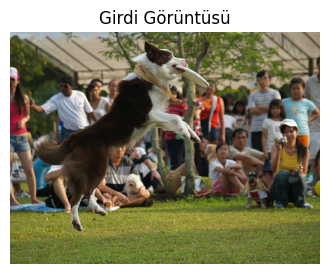


Adım 1: Metin Ön İşleme (Preprocessing)
HAM CÜMLE (Raw)                                              | İŞLENMİŞ CÜMLE (Processed)
----------------------------------------------------------------------------------------------------
A black and white Border Collie catches a Frisbee in front   | startseq black and white border collie catches frisbee in front of an audience endseq
a brown and white dog catches a Frisbee in it mouth in fro   | startseq brown and white dog catches frisbee in it mouth in front of group of people endseq

Adım 2: Görüntü Özellik Çıkarımı (Feature Extraction - CNN)
Görüntü VGG16 modelinden geçirildi ve aşağıdaki vektöre dönüştürüldü:
Vektör Boyutu: (1, 4096)
Vektör Örneği (İlk 20 sayı): [0.         0.         1.0149103  0.         0.         0.
 0.         1.9113584  0.         4.0964537  0.         0.
 0.         0.         0.         0.         0.         0.07782921
 1.2445879  0.        ]
...


In [12]:
# --- RAPOR İÇİN GÖRSELLEŞTİRME ---
# Rastgele bir ID seçelim
ornek_id = list(mapping.keys())[100] # 100. resmi örnek alalım
img_path = os.path.join(RESIM_KLASORU, ornek_id + '.jpg')

print(f"--- RAPOR İÇİN ÖRNEK VERİ ANALİZİ (ID: {ornek_id}) ---")

# 1. Resmi Göster
plt.figure(figsize=(4,4))
img = load_img(img_path)
plt.imshow(img)
plt.axis('off')
plt.title("Girdi Görüntüsü")
plt.show()

# 2. Metin Dönüşümü Tablosu
print("\nAdım 1: Metin Ön İşleme (Preprocessing)")
print(f"{'HAM CÜMLE (Raw)':<60} | {'İŞLENMİŞ CÜMLE (Processed)'}")
print("-" * 100)
for ham, temiz in zip(ham_veriler[ornek_id][:2], mapping[ornek_id][:2]):
    print(f"{ham[:58]:<60} | {temiz}")

# 3. Vektör Dönüşümü
print("\nAdım 2: Görüntü Özellik Çıkarımı (Feature Extraction - CNN)")
print("Görüntü VGG16 modelinden geçirildi ve aşağıdaki vektöre dönüştürüldü:")
print(f"Vektör Boyutu: {features[ornek_id].shape}")
print(f"Vektör Örneği (İlk 20 sayı): {features[ornek_id][0][:20]}")
print("...")

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

# 1. Tüm cümleleri tek bir listede toplayalım
tum_cumleler = []
for key in mapping.keys():
    for caption in mapping[key]:
        tum_cumleler.append(caption)

# 2. Tokenizer'ı Eğitelim (Kelime -> Sayı eşleştirmesi)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tum_cumleler)

# Kelime Dağarcığı Boyutu (Model için çok önemli)
# +1 ekliyoruz çünkü 0 indeksi "padding" (boşluk doldurma) için ayrılır.
vocab_size = len(tokenizer.word_index) + 1

# En uzun cümleyi bulalım (Tüm cümleleri buna göre sabitleyeceğiz)
max_length = max(len(caption.split()) for caption in tum_cumleler)

print(f"Kelime Dağarcığı (Vocab Size): {vocab_size}")
print(f"En Uzun Cümle (Max Length): {max_length} kelime")

# 3. Tokenizer'ı da Kaydedelim (İleride test yaparken lazım olacak)
tokenizer_path = '/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer kaydedildi: {tokenizer_path}")

print("-" * 30)

# 4. EĞİTİM VE TEST AYIRMA (TRAIN - TEST SPLIT)
# Resim ID'lerini bir listeye alalım
tum_resim_idleri = list(mapping.keys())

# Karıştıralım ki rastgele olsun (Sıralı olmasın)
np.random.shuffle(tum_resim_idleri)

# %90 Eğitim, %10 Test oranı belirleyelim
bolme_noktasi = int(len(tum_resim_idleri) * 0.90) # %90 yapalım, veri çok olsun, %10 test yeterli.

train_ids = tum_resim_idleri[:bolme_noktasi]
test_ids = tum_resim_idleri[bolme_noktasi:]

print(f"Toplam Resim Sayısı: {len(tum_resim_idleri)}")
print(f"Eğitim (Train) Seti : {len(train_ids)} resim")
print(f"Test (Sınav) Seti   : {len(test_ids)} resim")

Kelime Dağarcığı (Vocab Size): 8766
En Uzun Cümle (Max Length): 34 kelime
Tokenizer kaydedildi: /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/tokenizer.pkl
------------------------------
Toplam Resim Sayısı: 8091
Eğitim (Train) Seti : 7281 resim
Test (Sınav) Seti   : 810 resim


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Metin_Girdisi       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Goruntu_Girdisi     │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,244,096 │ Metin_Girdisi[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ Goruntu_Girdisi[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ Metin_Girdisi[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Cikis (Dense)       │ (None, 8766)      │  2,252,862 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,136,894 (23.41 MB)

 Trainable params: 6,136,894 (23.41 MB)

 Non-trainable params: 0 (0.00 B)

None


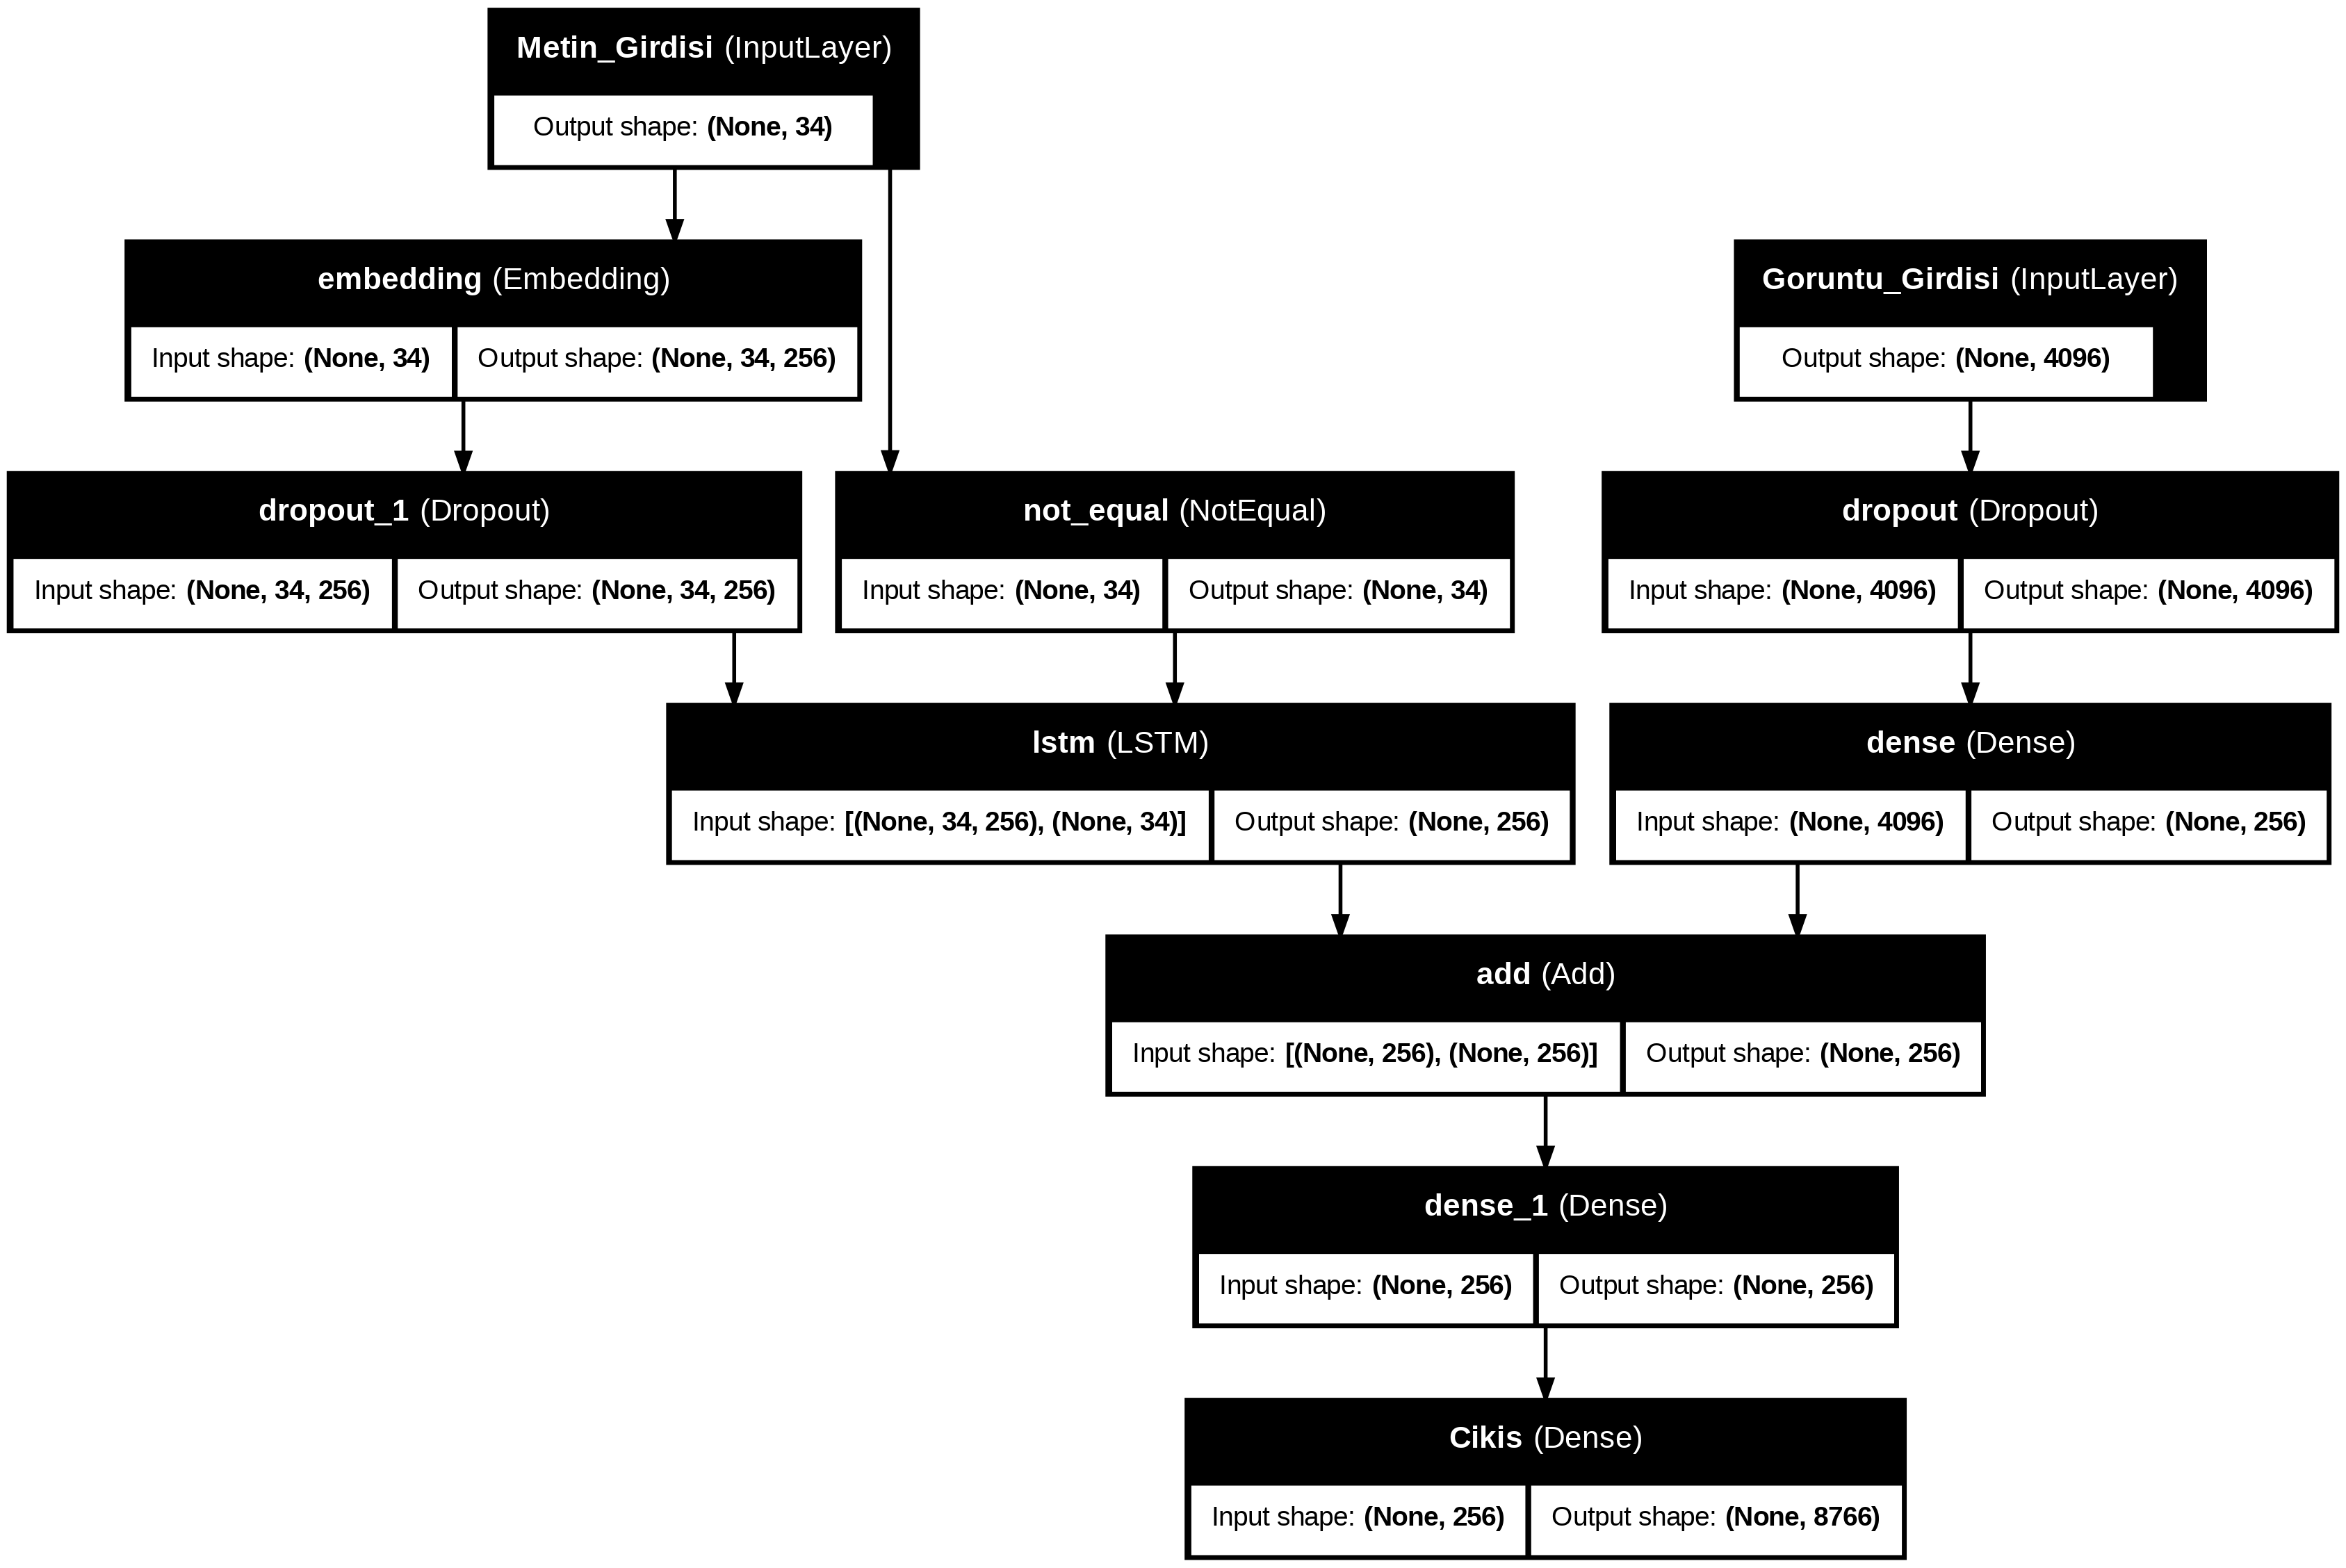

In [15]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# --- PARAMETRELER (Senin çıktılarından aldım) ---
vocab_size = 8766     # Kelime dağarcığı
max_length = 34       # Maksimum cümle uzunluğu
embedding_dim = 256   # Kelimelerin vektör büyüklüğü (Standarttır)
units = 256           # LSTM ve Dense katmanlarının nöron sayısı

# --- 1. KOL: GÖRÜNTÜ İŞLEME (Feature Extractor) ---
inputs1 = Input(shape=(4096,), name="Goruntu_Girdisi")
fe1 = Dropout(0.5)(inputs1) # Overfitting engellemek için %50'sini kapat
fe2 = Dense(units, activation='relu')(fe1) # 4096'yı 256'ya sıkıştır

# --- 2. KOL: METİN İŞLEME (Sequence Processor) ---
inputs2 = Input(shape=(max_length,), name="Metin_Girdisi")
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # Kelime -> Vektör
se2 = Dropout(0.5)(se1)
se3 = LSTM(units)(se2) # İşte LSTM burada!

# --- 3. BİRLEŞTİRME (Decoder) ---
decoder1 = add([fe2, se3]) # Görüntü ve Yazı bilgisini topla
decoder2 = Dense(units, activation='relu')(decoder1)

# --- ÇIKIŞ KATMANI ---
# Vocab size kadar çıkış veriyoruz, çünkü her kelime için bir olasılık hesaplayacak
outputs = Dense(vocab_size, activation='softmax', name="Cikis")(decoder2)

# Modeli oluştur
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Modeli derle (Compile)
# loss='categorical_crossentropy': Çünkü çok sınıflı (8766 kelime) bir sınıflandırma yapıyoruz.
# optimizer='adam': En popüler ve hızlı optimize edici.
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Model Özetini Yazdır
print(model.summary())

# --- RAPOR İÇİN ŞEMA ÇİZDİRME ---
# Bu resmi raporunun "Model Mimarisi" bölümüne koyacaksın. Harika durur.
plot_model(model, to_file='model_semasi.png', show_shapes=True, show_layer_names=True)

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

# --- 1. VERİ ÜRETECİ FONKSİYONU ---
def data_generator_func(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            feature = features[key][0]
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                # DÜZELTME 1: Listeleri numpy array'e çevirip TUPLE (Normal parantez) içinde gönderiyoruz
                # ((Girdi1, Girdi2), Çıktı)
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

# --- 2. TENSORFLOW DATASET OLUŞTURMA ---
output_signature = (
    (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),   # Görüntü Girdisi
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)), # Metin Girdisi (INT32 OLDU)
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)    # Çıktı
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator_func(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature
)

train_dataset = train_dataset.repeat()

# --- 3. EĞİTİM AYARLARI ---
epochs = 20
batch_size = 32
steps = len(train_ids) // batch_size

checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')

# --- 4. EĞİTİMİ BAŞLAT ---
print(f"Eğitim Başlıyor... Toplam {epochs} Epoch sürecek.")
print("Veri tipleri ve parantezler düzeltildi. Şimdi sorunsuz çalışmalı!")
print("-" * 50)

history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps,
    verbose=1,
    callbacks=[checkpoint]
)

# Kaydet
model.save('/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/final_model.h5')
print("\nEğitim Tamamlandı! Modeller Drive'a kaydedildi.")

Eğitim Başlıyor... Toplam 20 Epoch sürecek.
Veri tipleri ve parantezler düzeltildi. Şimdi sorunsuz çalışmalı!
--------------------------------------------------
Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 5.8654
Epoch 1: loss improved from inf to 5.18825, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1139s 5s/step - loss: 5.8624
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 4.1272
Epoch 2: loss improved from 5.18825 to 3.96879, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1122s 5s/step - loss: 4.1265
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 3.6468
Epoch 3: loss improved from 3.96879 to 3.56716, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1123s 5s/step - loss: 3.6465
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 3.3623
Epoch 4: loss improved from 3.56716 to 3.31284, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1124s 5s/step - loss: 3.3621
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 3.1569
Epoch 5: loss improved from 3.31284 to 3.11991, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1124s 5s/step - loss: 3.1567
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.9997
Epoch 6: loss improved from 3.11991 to 2.97099, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1113s 5s/step - loss: 2.9996
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.8785
Epoch 7: loss improved from 2.97099 to 2.85306, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1103s 5s/step - loss: 2.8784
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.7774
Epoch 8: loss improved from 2.85306 to 2.75627, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1112s 5s/step - loss: 2.7773
Epoch 9/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.6921
Epoch 9: loss improved from 2.75627 to 2.67634, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1108s 5s/step - loss: 2.6920
Epoch 10/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.6170
Epoch 10: loss improved from 2.67634 to 2.60811, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1115s 5s/step - loss: 2.6169
Epoch 11/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.5612
Epoch 11: loss improved from 2.60811 to 2.55151, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1105s 5s/step - loss: 2.5611
Epoch 12/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.5138
Epoch 12: loss improved from 2.55151 to 2.50032, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1105s 5s/step - loss: 2.5138
Epoch 13/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.4645
Epoch 13: loss improved from 2.50032 to 2.45164, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1108s 5s/step - loss: 2.4644
Epoch 14/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.4233
Epoch 14: loss improved from 2.45164 to 2.41207, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1104s 5s/step - loss: 2.4233
Epoch 15/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.3809
Epoch 15: loss improved from 2.41207 to 2.37142, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1102s 5s/step - loss: 2.3808
Epoch 16/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.3490
Epoch 16: loss improved from 2.37142 to 2.33730, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1113s 5s/step - loss: 2.3489
Epoch 17/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.3098
Epoch 17: loss improved from 2.33730 to 2.30236, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1096s 5s/step - loss: 2.3098
Epoch 18/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.2762
Epoch 18: loss improved from 2.30236 to 2.26870, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1106s 5s/step - loss: 2.2762
Epoch 19/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.2411
Epoch 19: loss improved from 2.26870 to 2.23719, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1106s 5s/step - loss: 2.2411
Epoch 20/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.2180
Epoch 20: loss improved from 2.23719 to 2.21286, saving model to /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1118s 5s/step - loss: 2.2180



Eğitim Tamamlandı! Modeller Drive'a kaydedildi.


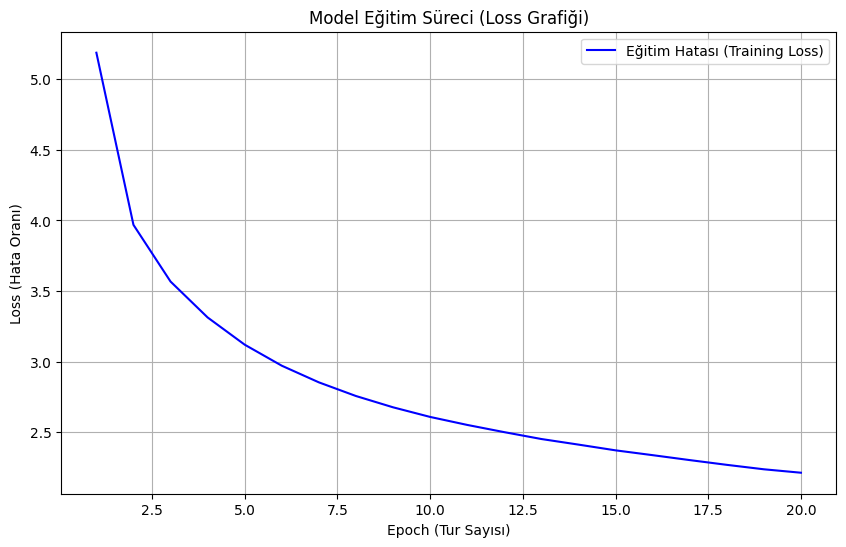

Bu grafik, modelin 20 tur boyunca nasıl öğrendiğini gösteriyor.
Grafiğin aşağı doğru inmesi başarının kanıtıdır.


In [19]:
import matplotlib.pyplot as plt

# History bilgisini alalım
loss_degerleri = history.history['loss']
epoch_sayilari = range(1, len(loss_degerleri) + 1)

# Grafiği Çiz
plt.figure(figsize=(10, 6))
plt.plot(epoch_sayilari, loss_degerleri, 'b-', label='Eğitim Hatası (Training Loss)')
plt.title('Model Eğitim Süreci (Loss Grafiği)')
plt.xlabel('Epoch (Tur Sayısı)')
plt.ylabel('Loss (Hata Oranı)')
plt.legend()
plt.grid(True)
plt.savefig('loss_grafigi.png') # Resmi kaydeder
plt.show()

print("Bu grafik, modelin 20 tur boyunca nasıl öğrendiğini gösteriyor.")
print("Grafiğin aşağı doğru inmesi başarının kanıtıdır.")

Test setinden rastgele resimler seçiliyor...


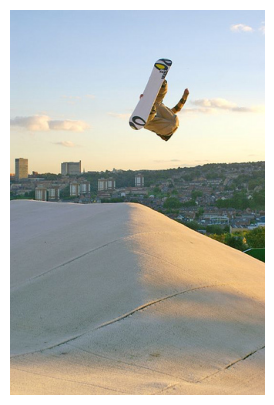


------------------------------------------------
GERÇEK AÇIKLAMA (İnsandan): startseq snowboarder is doing flip over mound of snow endseq
YAPAY ZEKA TAHMİNİ: buy in the ocean
------------------------------------------------



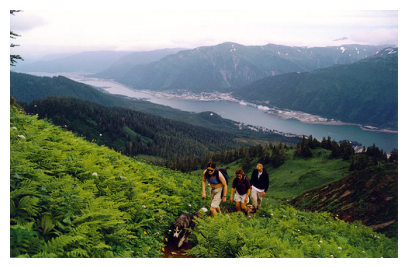


------------------------------------------------
GERÇEK AÇIKLAMA (İnsandan): startseq group of hikers led by black and white dog climbs hillside trail covered in ferns endseq
YAPAY ZEKA TAHMİNİ: man in red shirt standing on the grass with mountain
------------------------------------------------



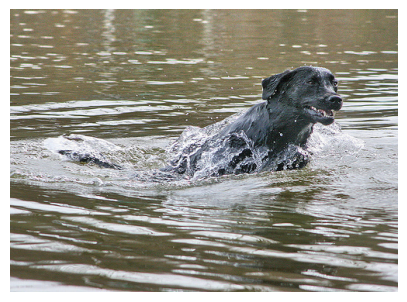


------------------------------------------------
GERÇEK AÇIKLAMA (İnsandan): startseq black dog swimming through river endseq
YAPAY ZEKA TAHMİNİ: black dog swimming in the water
------------------------------------------------



In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# --- YARDIMCI FONKSİYONLAR ---
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    # startseq ve endseq kelimelerini temizleyelim ki cümle güzel görünsün
    final_cumle = in_text.replace('startseq ', '').replace(' endseq', '')
    return final_cumle

# --- TEST İŞLEMİ ---
print("Test setinden rastgele resimler seçiliyor...")

# Test için ayırdığımız 'test_ids' listesinden rastgele 3 tane seç
import random
random_test_ids = random.sample(test_ids, 3)

for image_id in random_test_ids:
    # 1. Resmi Bul ve Göster
    img_path = os.path.join(RESIM_KLASORU, image_id + '.jpg')
    img = plt.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # 2. Resmin Özelliğini Al (Features sözlüğünden)
    # Model eğitimi sırasında özellikleri zaten çıkarmıştık, tekrar VGG'ye sokmaya gerek yok
    feature = features[image_id]

    # 3. Yorum Yaptır
    yorum = generate_desc(model, tokenizer, feature, max_length)

    print("\n------------------------------------------------")
    print(f"GERÇEK AÇIKLAMA (İnsandan): {mapping[image_id][0]}") # İlk gerçek cümleyi göster
    print(f"YAPAY ZEKA TAHMİNİ: \033[1m{yorum}\033[0m") # Kalın fontla yaz
    print("------------------------------------------------\n")